In [221]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from pandas_datareader import data as pdr
from faker import Faker
import matplotlib.pyplot as plt
import ta
import datetime

In [222]:
fake = Faker()
start_date = fake.date_between(start_date=datetime.date(2010,1,1), end_date='now')
end_date = fake.date_between(start_date=start_date, end_date='now')

start_date=datetime.date(2016,1,1)
end_date=datetime.date(2018,1,1)

#df = yf.Ticker("SPY").history(period = '1y', interval = '1d').reset_index()[["Date", "Close"]]
df = pdr.get_data_yahoo("SPY", start=start_date,  end=end_date).reset_index()[["Date", "Close"]]

In [223]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window = 14).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_Diff'] = ta.trend.MACD(df['Close']).macd_diff()
df['EMA50'] = ta.trend.EMAIndicator(df['Close'], window = 50).ema_indicator()
df['EMA100'] = ta.trend.EMAIndicator(df['Close'], window = 100).ema_indicator()
df['EMA200'] = ta.trend.EMAIndicator(df['Close'], window = 200).ema_indicator()
df
#df.to_csv("stock_date.csv")

,Date,Close,RSI,MACD,Signal,MACD_Diff,EMA50,EMA100,EMA200
0,2021-01-04,368.790009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-05,371.329987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-06,373.549988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-07,379.100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-08,381.260010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
386,2022-07-18,381.950012,46.400799,-3.089468,-4.096230,1.006762,394.065390,408.717451,420.334852
387,2022-07-19,392.269989,54.911595,-2.079563,-3.692896,1.613334,393.994983,408.391759,420.055599
388,2022-07-20,394.769989,56.705068,-1.065198,-3.167357,2.102159,394.025375,408.122021,419.804001
389,2022-07-21,398.790009,59.495107,0.062357,-2.521414,2.583771,394.212223,407.937229,419.594907


In [224]:
debug = False
adaptive_stoploss = False
buy = False
sell = False
long_stoploss = None
long_max_profit = None
short_stoploss = None
short_max_profit = None
buy_list = []
sell_list = []

for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= long_stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False    
        if debug:
            print("Date: ", df.Date[i], "Stoploss Hit - Sell at $", df.Close[i])
        
    elif buy == True and df.Close[i] >= long_max_profit:
        if adaptive_stoploss:
            long_stoploss = df.Close[i] * 0.99
            long_max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Date: ", df.Date[i], "Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            long_stoploss = None
            long_max_profit = None
            buy = False   
            if debug: 
                print("Date: ", df.Date[i], "Max Profit Reached - Sell at $", df.Close[i])
                
    elif sell == True and df.Close[i] >= short_stoploss:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False
        if debug:
            print("Date: ", df.Date[i], "Short Stoploss Hit - Buy Back at $", df.Close[i])
        
    elif sell == True and df.Close[i] <= short_max_profit:
        if adaptive_stoploss:
            short_stoploss = df.Close[i] * 1.01
            short_max_profit = df.Close[i] * 0.97
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print("Date: ", df.Date[i], "Max Profit Reached - Updated Stoploss")         
        else:
            buy_list.append(df.Close[i])
            sell_list.append(np.nan)
            short_stoploss = None
            short_max_profit = None
            sell = False   
            if debug: 
                print("Date: ", df.Date[i], "Short Max Profit Reached - Buy Back at $", df.Close[i])
        
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and sell == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        long_stoploss = df.Close[i] * 0.99
        long_max_profit = df.Close[i] * 1.03
        buy = True
        if debug:
            print("Date: ", df.Date[i], "Buy at $", df.Close[i])

            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True and sell == False:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False
        if debug:
            print("Date: ", df.Date[i], "Momentum Changed - Sell at $", df.Close[i])
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == False and sell == False:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        short_stoploss = df.Close[i] * 1.01
        short_max_profit = df.Close[i] * 0.97
        sell = True
        if debug:
            print("Date: ", df.Date[i], "Short Sell at $", df.Close[i])
            
            
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False  and sell == True:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False
        if debug:
            print("Date: ", df.Date[i], "Momentum Changed - Buy Back at $", df.Close[i])
            
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) > len(Sells):
    Buys = Buys[:-1]
elif len(Buys) < len(Sells):
    Sells = Sells[:-1]
    
profit1 = sum(Sells) - sum(Buys)
print('Profit: ', profit1)

Profit:  56.76007080078125


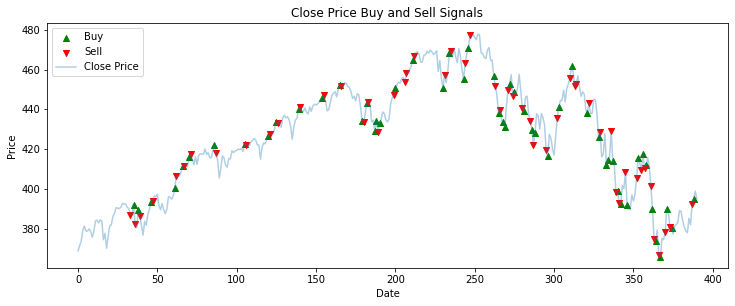

In [225]:

plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

In [229]:
debug = True
adaptive_stoploss = False
short_sale = False
buy = False
sell = False
long_stoploss = None
long_max_profit = None
short_stoploss = None
short_max_profit = None
buy_list = []
sell_list = []


for i in range(len(df)):
    #print(df.Date[i], df.Close[i])
    
    if buy == True and df.Close[i] <= long_stoploss:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False    
        if debug:
            print(f"{df.Date[i]} - Long position Stoploss Hit - Sell at ${df.Close[i]}")

    elif sell == True and df.Close[i] >= short_stoploss:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False    
        if debug:
            print(f"{df.Date[i]} - Short position Stoploss Hit - Buy Back at ${df.Close[i]}")
        
    elif buy == True and df.Close[i] >= long_max_profit:
        if adaptive_stoploss:
            long_stoploss = df.Close[i] * 0.99
            long_max_profit = df.Close[i] * 1.03
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            if debug: 
                print(f"{df.Date[i]} - Long position Max Profit Reached - Updated Stoploss")         
        else:
            sell_list.append(df.Close[i])
            buy_list.append(np.nan)
            long_stoploss = None
            long_max_profit = None
            buy = False   
            if debug: 
                print(f"{df.Date[i]} - Long position Max Profit Reached - Sell at ${df.Close[i]}")
                
                
    elif sell == True and df.Close[i] <= short_max_profit:
        if adaptive_stoploss:
            short_stoploss = df.Close[i] * 1.01
            short_max_profit = df.Close[i] * 0.985
            sell_list.append(np.nan)
            buy_list.append(np.nan)
            if debug: 
                print(f"{df.Date[i]} - Short position Max Profit Reached - Updated Stoploss")         
        else:
            buy_list.append(df.Close[i])
            sell_list.append(np.nan)
            short_stoploss = None
            short_max_profit = None
            sell = False   
            if debug: 
                print(f"{df.Date[i]} - Short position Max Profit Reached - Sell at ${df.Close[i]}")
        
    elif (df.MACD_Diff[i] > df.Signal[i]) and (df.Close[i] > df.EMA100[i] or df.RSI[i] > 50) and buy == False and sell == False:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        long_stoploss = df.Close[i] * 0.99
        long_max_profit = df.Close[i] * 1.025
        buy = True
        if debug:
            print(f"{df.Date[i]} - Buy at ${df.Close[i]}")
            
    elif df.MACD_Diff[i] < df.Signal[i] and buy == True and sell == False:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        long_stoploss = None
        long_max_profit = None
        buy = False
        if debug:
            print(f"{df.Date[i]} - Close Long Position - Sell at ${df.Close[i]}")
            
    elif (df.MACD_Diff[i] < df.Signal[i]) and (df.Close[i] < df.EMA100[i] or df.RSI[i] < 50) and sell == False and buy == False and short_sale:
        sell_list.append(df.Close[i])
        buy_list.append(np.nan)
        short_stoploss = df.Close[i] * 1.01
        short_max_profit = df.Close[i] * 0.975
        sell = True
        if debug:
            print(f"{df.Date[i]} - Short Sell at ${df.Close[i]}")
            
    elif df.MACD_Diff[i] > df.Signal[i] and buy == False and sell == True:
        buy_list.append(df.Close[i])
        sell_list.append(np.nan)
        short_stoploss = None
        short_max_profit = None
        sell = False
        if debug:
            print(f"{df.Date[i]} - Close Short Position - Buy Back at ${df.Close[i]}")
            
            
    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)
        
        
df['Buy_Signal_Price'] = buy_list
df['Sell_Signal_Price'] = sell_list
capital = 100000
holding = 0
long = False
short = False
price_position = 0

for i in range(len(df)):
    
    price_position = df.Close[i]

    
    if df.Buy_Signal_Price[i] > 0 and long == False and short == False:
        holding = capital / df.Close[i]
        capital = 0
        long = True
                
    elif df.Sell_Signal_Price[i] > 0 and long == True and short == False:
        capital += df.Close[i] * holding
        holding = 0
        long = False
        
    elif df.Sell_Signal_Price[i] > 0 and short == False and long == False:

        holding = capital * 0.5/ df.Close[i] 
        capital += holding * df.Close[i] 
        short = True
        
    elif df.Buy_Signal_Price[i] > 0 and short == True and long == False:
        capital -= holding * df.Close[i]
        holding = 0
        short = False
    
        

Buys = [x for x in df['Buy_Signal_Price']  if math.isnan(x) == False]
Sells = [x for x in df['Sell_Signal_Price']  if math.isnan(x) == False]

if len(Buys) > len(Sells):
    Buys = Buys[:-1]
    capital = price_position * holding
elif len(Buys) < len(Sells):
    Sells = Sells[:-1]
    capital = -price_position * holding

profit2 = sum(Sells) - sum(Buys)
print(f'Unit Profit: {profit2}, Portfolio Balance = {capital}')

2021-10-01 00:00:00 - Buy at $434.239990234375
2021-10-04 00:00:00 - Long position Stoploss Hit - Sell at $428.6400146484375
2021-10-05 00:00:00 - Buy at $433.1000061035156
2021-10-15 00:00:00 - Long position Max Profit Reached - Sell at $445.8699951171875
2021-10-18 00:00:00 - Buy at $447.19000244140625
2021-10-27 00:00:00 - Close Long Position - Sell at $453.94000244140625
2022-02-02 00:00:00 - Buy at $457.3500061035156
2022-02-03 00:00:00 - Long position Stoploss Hit - Sell at $446.6000061035156
2022-02-09 00:00:00 - Buy at $457.5400085449219
2022-02-10 00:00:00 - Long position Stoploss Hit - Sell at $449.32000732421875
2022-03-16 00:00:00 - Buy at $435.6199951171875
2022-03-22 00:00:00 - Long position Max Profit Reached - Sell at $449.5899963378906
2022-03-23 00:00:00 - Buy at $443.79998779296875
2022-03-28 00:00:00 - Long position Max Profit Reached - Sell at $455.9100036621094
2022-03-29 00:00:00 - Buy at $461.54998779296875
2022-03-31 00:00:00 - Long position Stoploss Hit - Sell

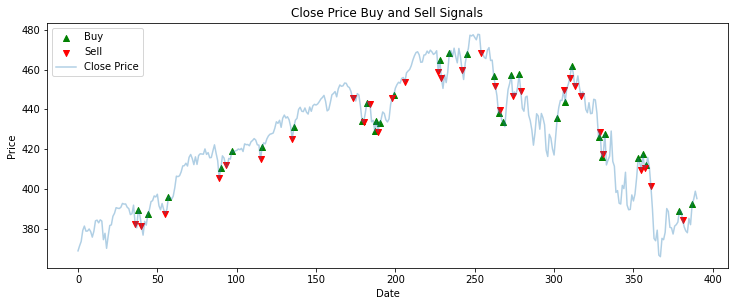

In [227]:
plt.figure(figsize=(12.2,4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green', label = 'Buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red', label = 'Sell', marker = 'v', alpha = 1)
plt.plot(df['Close'], label = 'Close Price', alpha = 0.35)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = "upper left")
plt.show()

In [228]:
print(start_date, end_date)
print('Pure MACD', profit1)

2021-01-01 2023-01-01
Pure MACD 56.76007080078125
